# Бибилотеки

In [ ]:
# Numpy
import numpy as np

# Pandas
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset, Dataset

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

# Matplotlib и plotly
import matplotlib.pyplot as plt
import plotly.express as px

# cv2
import cv2

# OS
import os
from tqdm.auto import tqdm

import random
from typing import Dict, List, Optional, Tuple, Union

# Вспомогательные функции

In [ ]:
# Работа с данными
TITLE_FONT_SIZE = 16

def prepare_images(train_data: np.ndarray, test_data: Optional[np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray]:
    train_data = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train_data])
    train_data = train_data / 255.0
    train_data = np.expand_dims(train_data, axis=3)
    train_data = np.transpose(train_data, (0, 3, 1, 2))

    if test_data is not None:
        train_data = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train_data])
        test_data = test_data / 255.0
        train_data = np.expand_dims(train_data, axis=3)
        test_data = np.transpose(test_data, (0, 3, 1, 2))
        return train_data, test_data

    return train_data

def load_CIFAR10(
    with_targets: bool = False, is_train=True,
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    dataset = CIFAR10(root="./", train=is_train, download=False)
    data = dataset.data

    if with_targets:
        labels = np.array(dataset.targets)
        return data, labels

    return data

def load_dataset(
    is_train: bool = True,
    classes: Optional[List[int]] = None,
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:

    data, labels = load_CIFAR10(with_targets=True, is_train=is_train)
    data = data.astype("float32")

    data = prepare_images(data)

    if classes is not None:
        mask = np.isin(labels, classes)
        data = data[mask]

    return data

def show_samples(
    samples: np.ndarray,
    title: str,
    figsize: Optional[Tuple[int, int]] = None,
    nrow: Optional[int] = None,
) -> None:
    if isinstance(samples, np.ndarray):
        samples = torch.tensor(samples)
    samples = samples.float()
    if (samples > 1).any():
        samples /= 255
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)

    grid_img = grid_img.clip(0, 1)
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()


def visualize_images(data: np.ndarray, title: str) -> None:
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)

# Загрузка датасета

In [ ]:
train_dataset = CIFAR10(root="./", train=True, download=True)
test_dataset = CIFAR10(root="./", train=False, download=True)

100%|██████████| 170M/170M [00:05<00:00, 29.3MB/s]


# Модель автоэнкодера

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 32, 32)
        return decoded

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


# Семплирование данных

In [ ]:
def sample_data(data: np.ndarray, num_elements: int) -> np.ndarray:
    """
    Семплирование из выборки

    Args:
        data: выборка
        num_elements: количество элементов для семплирования

    Returns:
        Семплы из входной выборки
    """
    random_indices = np.random.choice(data.shape[0], num_elements, replace=False)
    return data[random_indices]

def get_data_mix(
    class_1_data: np.ndarray,
    class_3_data: np.ndarray,
    num_samples: int = 2000,
    class3_proportion: float = 0.1,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Семплирование выборки для обучения автоэнкодера,
    содержащей случайные семплы из 3 класса

    Args:
        class_1_data: выборка основного класса, откуда будет семплирование
        class_3_data: выборка подмешиваемого класса, откуда будет семплирование
        num_samples: суммарный размер итоговой выборки
        class3_proportion: доля подмешиваемого класса в итоговой выборке

    Returns:
        Выборка для обучения автоэнкодера
    """
    num_base_samples = int(num_samples * (1 - class3_proportion))
    num_class3_samples = num_samples - num_base_samples

    train_1_data = sample_data(class_1_data, num_base_samples)
    train_3_data = sample_data(class_3_data, num_class3_samples)

    train_data = np.concatenate([train_1_data, train_3_data])

    return train_data

def get_data_equal(
    class_1_data: np.ndarray,
    class_3_data: np.ndarray,
    num_samples: int = 2000,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Семплирование выборки для обучения автоэнкодера
    с фиксированной выборкой для подмешиваемого класса

    Args:
        class_1_data: выборка основного класса, откуда будет семплирование
        class_3_data: выборка подмешиваемого класса. Семплируется заранее и добавляется целиком
        num_samples: суммарный размер итоговой выборки

    Returns:
        Выборка для обучения автоэнкодера, содержащая весь class_3_data
    """
    num_class3_samples = class_3_data.shape[0]
    num_base_samples = num_samples - num_class3_samples

    train_1_data = sample_data(class_1_data, num_base_samples)

    train_data = np.concatenate([train_1_data, class_3_data])

    return train_data

def get_data_pair(
    class_1_data: np.ndarray,
    class_2_data: np.ndarray,
    class_3_data: np.ndarray,
    num_samples: int = 2000,
    class3_proportion: float = 0.1,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Семплирование выборок для обучения автоэнкодеров
    на двух разных классах с одинаковой примесью третьего класса

    Args:
        class_1_data: выборка первого основного класса, откуда будет семплирование
        class_2_data: выборка второго основного класса, откуда будет семплирование
        class_3_data: выборка подмешиваемого класса, откуда будет семплирование
        num_samples: суммарный размер итоговой выборки
        class3_proportion: доля подмешиваемого класса в итоговых выборках

    Returns:
        Выборки для обучения автоэнкодеров,
        содержащие случайные семплы из 1 и 2 класса и одинаковые семплы из 3 класса
    """
    num_base_samples = int(num_samples * (1 - class3_proportion))
    num_class3_samples = num_samples - num_base_samples

    train_1_data = sample_data(class_1_data, num_base_samples)
    train_2_data = sample_data(class_2_data, num_base_samples)
    train_3_data = sample_data(class_3_data, num_class3_samples)

    train_1_data = np.concatenate([train_1_data, train_3_data])
    train_2_data = np.concatenate([train_2_data, train_3_data])

    return train_1_data, train_2_data

# Векторизация автоэнкодеров

In [ ]:
def extract_singular_values_from_layer(weight_tensor: np.array) -> np.array:
    """
    Получение сингулярных значений для слоя

    Args:
        weight_tensor: массив весов слоя

    Returns:
        Сингулярные значения слоя
    """
    if len(weight_tensor.shape) == 4:  # Для свёрточных слоёв
        out_channels, in_channels, kernel_height, kernel_width = weight_tensor.shape
    else:  # Для линейных слоёв
        out_channels, in_channels = weight_tensor.shape
    weight_matrix = weight_tensor.reshape(out_channels, -1)

    U, S, Vt = np.linalg.svd(weight_matrix)
    return S

def extract_singular_values_from_weights(weights: List[np.array]) -> List[np.array]:
    """
    Вычисление сингулярных значений для каждого слоя

    Args:
        weights: список весов всех слоёв

    Returns:
        Список сингулярных значений для каждого слоя
    """
    singular_values_list = []
    for layer_weights in weights:
        singular_values = extract_singular_values_from_layer(layer_weights)
        singular_values_list.append(singular_values)
    return singular_values_list

def get_vector(model: Autoencoder) -> np.array:
    """
    Кодирование модели с помощью сингулярных чисел её весов

    Args:
        model: модель автоэнкодера, имеет encoder и decoder

    Returns:
        Сингулярные числа весов модели, вытянутые в вектор
    """
    model.eval()
    weights = []
    with torch.no_grad():
      for layer in model.encoder:  # [model.encoder]
          if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
              weights.append(layer.weight.data.cpu().numpy())
      for layer in model.decoder:  # [model.decoder]
          if isinstance(layer, nn.ConvTranspose2d) or isinstance(layer, nn.Linear):
              weights.append(layer.weight.data.cpu().numpy())
      singular_values_list = extract_singular_values_from_weights(weights)
    return np.concatenate(singular_values_list)

# Обучение автоэнкодеров

In [ ]:
def train_model(model: Autoencoder, train_loader: DataLoader, num_epochs: int) -> Autoencoder:
    """
    Обучение автоэнкодера

    Args:
        model: модель автоэнкодера
        train_loader: загрузчик данных для обучения
        num_epochs: количество эпох обучения

    Returns:
        Обученная модель
    """
    model.to(DEVICE)
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        for inputs_list in train_loader:
            inputs = inputs_list[0]  # Особенность TensorDataset в DataLoader

            # ============ Forward ============
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            # ============ Backward ============
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

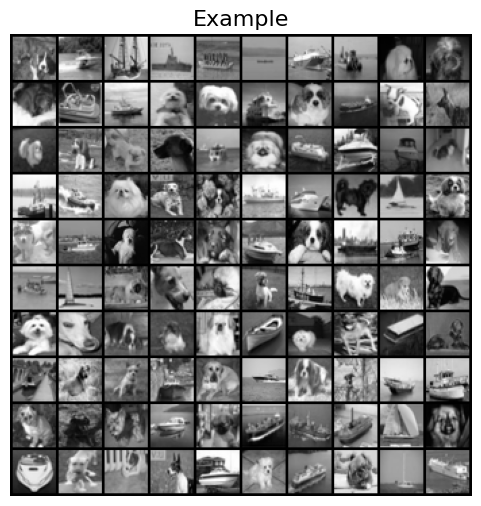

In [ ]:
INPUT_DIM = 1024  # 1x32x32
HIDDEN_DIM = 256

num_models_train = 100  # Число автоэнкодеров для обучения регрессии на их векторах
num_models_test = 50 # Число автоэнкодеров для тестирования регрессии на их векторах
NUM_EPOCHS = 20  # Параметры обучения одного автоэнкодера
BATCH_SIZE = 32  # Параметры обучения одного автоэнкодера

# Основной класс 1 (собаки), основной класс 2 (лягушки), подмешиваемый класс (корабли)
classes = [5, 6, 8]

# Доля подмешиваемого класса в обучающих выборках
proportions = [0.6]  # [0.6, 0.7, 0.8, 0.85, 0.87, 0.9, 0.925, 0.95, 0.972, 0.99]

# Предварительная выгрузка классов, из которых будет семплирование
class_1_data = load_dataset(is_train=True, classes=classes[0])
class_2_data = load_dataset(is_train=True, classes=classes[1])
class_3_data = load_dataset(is_train=True, classes=classes[2])

# Пример использования функций семплирования для 3 экспериментов
train_data = get_data_mix(class_1_data, class_3_data, num_samples=2000, class3_proportion=0.5)
# train_data = get_data_equal(class_1_data, sample_data(class_3_data, 1000), num_samples=2000)
# train_data, _ = get_data_pair(class_1_data, class_2_data, class_3_data, num_samples=2000, class3_proportion=0.5)

visualize_images(train_data, "Example")

In [ ]:
import json

def create_folder_structure(base_dir: str, proportions: List[int]) -> None:
    """
    Создание папок для сохранения моделей эксперимента и их веторов
        - base_dir:
            - Proportion_0.6
              - train
              - test
            - Proportion_0.7
            - ...
            - Proportion_0.99

    Args:
        base_dir: базовая директория для сохранения
        proportions: список долей подмешиваемого класса
    """
    for proportion in proportions:
        config_name = f"Proportion_{proportion}"
        config_path = os.path.join(base_dir, config_name)
        os.makedirs(os.path.join(config_path, "train"), exist_ok=True)
        os.makedirs(os.path.join(config_path, "test"), exist_ok=True)
        print(f"Created folder structure for {config_name}")

base_dir = "proportions_mix"
create_folder_structure(base_dir, proportions)

Created folder structure for Proportion_0.6


## Подмешиваемый класс разный для всех или одинаковый для всех

In [ ]:
def train_models(
    num_models: int,
    data_1: np.array,
    data_3: np.array,
    proportion: float,
    output_path: str,
    model_class: int,
    mode: str = "train"
) -> Tuple[List[np.array], List[Dict[str, Union[int, str]]]]:
    """
    Обучение нескольких автоэнкодеров в цикле с сохранением весов и векторов

    Args:
        num_models: количество обучаемых автоэнкодеров
        data_1: выборка основного класса, откуда будет семплирование
        data_3: выборка подмешиваемого класса, откуда будет семплирование
        proportion: доля подмешиваемого класса
        output_path: путь для сохранения весов моделей
        model_class: основной класс модели (1 (собаки) или 2(лягушки))
        mode: для чего будут использоваться обученные автоэнкодеры, "train" или "test"

    Returns:
        vectors: список векторов закодированных автоэнкодеров
        metadata: список metadata энкодеров (порядковый номер и путь сохранения)
    """
    vectors = []
    metadata = []
    for i in tqdm(range(num_models)):
        train_data_np = get_data_mix(data_1, data_3, num_samples=2000, class3_proportion=proportion)  # Случайный 3 класс везде
        # train_data_np = get_data_equal(data_1, data_3, num_samples=2000)  # Одинаковый 3 класс везде
        train_data_tensor = torch.tensor(train_data_np).float().to(DEVICE)  # Для ускорения кладём сразу всю выборку на GPU
        train_dataset_tensor = TensorDataset(train_data_tensor)
        train_loader = DataLoader(train_dataset_tensor, batch_size=BATCH_SIZE, shuffle=True)

        model = Autoencoder(INPUT_DIM, HIDDEN_DIM)
        trained_model = train_model(model, train_loader, NUM_EPOCHS)
        vector = get_vector(trained_model)
        vectors.append(vector)

        model_path = os.path.join(output_path, mode, f"model_{model_class}_{i}.pt")
        torch.save(trained_model.state_dict(), model_path)

        metadata.append({
            "model_id": model_class * num_models + i,
            "path": f"{mode}/model_{model_class}_{i}.pt"
        })
    return vectors, metadata

In [ ]:
for proportion in proportions:
    config_name = f"Proportion_{proportion}"
    print(f"\n=== Processing configuration: {config_name} ===")
    output_path = os.path.join(base_dir, config_name)

    # Метаданные эксперимента
    metadata = {
        "input_dim": INPUT_DIM,
        "hidden_dim": HIDDEN_DIM,
        "proportion": proportion,
        "train_models": [],
        "test_models": []
    }

    # Для случая одинакового подмешиваемого 3 класса
    # num_class3_samples = int(2000 * proportion)
    # class_3_sampled = sample_data(class_3_data, num_class3_samples)

    for model_class in [0, 1]:  # Класс, на котором обучается модель (собаки или лягушки)
        print(f"Training {num_models_train} train models, class {model_class}...")
        if model_class == 0:
            base_data = class_1_data
        else:
            base_data = class_2_data

        vectors, metadata_add = train_models(
            num_models_train, base_data, class_3_data, proportion, output_path, model_class
        )
        metadata["train_models"].extend(metadata_add)
        np.save(os.path.join(output_path, "train", f"vectors_{model_class}.npy"), vectors)

    for model_class in [0, 1]:
        print(f"Training {num_models_test} test models, class {model_class}...")
        if model_class == 0:
            base_data = class_1_data
        else:
            base_data = class_2_data

        vectors, metadata_add = train_models(
            num_models_test, base_data, class_3_data, proportion, output_path, model_class, mode="test"
        )
        metadata["test_models"].extend(metadata_add)
        np.save(os.path.join(output_path, "test", f"vectors_{model_class}.npy"), vectors)

    # Сохраняем метаданные конфигурации
    metadata_path = os.path.join(output_path, "metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"Completed configuration {config_name}. Models saved to {output_path}")


=== Processing configuration: Proportion_0.6 ===
Training 100 train models, class 1...


  0%|          | 0/100 [00:00<?, ?it/s]

Training 50 test models, class 1...


  0%|          | 0/50 [00:00<?, ?it/s]

Completed configuration Proportion_0.6. Models saved to proportions_mix/Proportion_0.6


## Подмешиваемый класс одинаковый для пар

In [ ]:
def train_models_pair(
    num_models: int,
    data_1: np.array,
    data_2: np.array,
    data_3: np.array,
    proportion: float,
    output_path: str,
    mode: str = "train"
) -> Tuple(List[np.array], List[np.array], List[Dict[str, Union[int, str]]]):
    """
    Обучение нескольких автоэнкодеров в цикле с сохранением весов и векторов.
    Отдельный пайплай в случае, когда для каждой пары моделей разного класса одинаковые семплы подмешиваемого класса

    Args:
        num_models: количество обучаемых автоэнкодеров
        data_1: выборка первого основного класса, откуда будет семплирование
        data_2: выборка второго основного класса, откуда будет семплирование
        data_3: выборка подмешиваемого класса, откуда будет семплирование
        proportion: доля подмешиваемого класса
        output_path: путь для сохранения весов моделей
        mode: для чего будут использоваться обученные автоэнкодеры, "train" или "test"

    Returns:
        vectors_1: список векторов закодированных автоэнкодеров 1 класса
        vectors_2: список векторов закодированных автоэнкодеров 2 класса
        metadata: список metadata энкодеров (порядковый номер и путь сохранения)
    """
    vectors_1 = []
    vectors_2 = []
    metadata = []
    for i in tqdm(range(num_models)):
        train_data_np_1, train_data_np_2 = get_data_pair(
            data_1, data_2, data_3, num_samples=2000, class3_proportion=proportion
        )

        for model_class, train_data_np in enumerate([train_data_np_1, train_data_np_2]):
            train_data_tensor = torch.tensor(train_data_np).float().to(DEVICE)
            train_dataset_tensor = TensorDataset(train_data_tensor)
            train_loader = DataLoader(train_dataset_tensor, batch_size=BATCH_SIZE, shuffle=True)

            model = Autoencoder(INPUT_DIM, HIDDEN_DIM)
            trained_model = train_model(model, train_loader, NUM_EPOCHS)

            if model_class == 0:
                vectors_1.append(get_vector(trained_model))
            else:
                vectors_2.append(get_vector(trained_model))

            model_path = os.path.join(output_path, mode, f"model_{model_class}_{i}.pt")
            torch.save(trained_model.state_dict(), model_path)

            metadata.append({
                "model_id": model_class * num_models + i,
                "path": f"{mode}/model_{model_class}_{i}.pt"
            })
    return vectors_1, vectors_2, metadata

In [ ]:
for proportion in proportions:
    config_name = f"Proportion_{proportion}"
    print(f"\n=== Processing configuration: {config_name} ===")
    output_path = os.path.join(base_dir, config_name)

    # Метаданные эксперимента
    metadata = {
        "input_dim": INPUT_DIM,
        "hidden_dim": HIDDEN_DIM,
        "proportion": proportion,
        "train_models": [],
        "test_models": []
    }

    print(f"Training {num_models_train} train models")
    vectors_0, vectors_1, metadata_add = train_models_pair(
        num_models_train, class_1_data, class_2_data, class_3_data, proportion, output_path
    )
    metadata["train_models"].extend(metadata_add)
    np.save(os.path.join(output_path, "train", f"vectors_0.npy"), vectors_0)
    np.save(os.path.join(output_path, "train", f"vectors_1.npy"), vectors_1)

    print(f"Training {num_models_test} test models")
    vectors_0, vectors_1, metadata_add = train_models_pair(
        num_models_test, class_1_data, class_2_data, class_3_data, proportion, output_path, mode="test"
    )
    metadata["test_models"].extend(metadata_add)
    np.save(os.path.join(output_path, "test", f"vectors_0.npy"), vectors_0)
    np.save(os.path.join(output_path, "test", f"vectors_1.npy"), vectors_1)

    # Сохраняем метаданные конфигурации
    metadata_path = os.path.join(output_path, "metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"Completed configuration {config_name}. Models saved to {output_path}")

# Оценка результатов


In [ ]:
proportion = "0.6"

vectors_1 = np.load(f'./{base_dir}/Proportion_{proportion}/train/vectors_0.npy')
vectors_2 = np.load(f'./{base_dir}/Proportion_{proportion}/train/vectors_1.npy')
vectors_1_test = np.load(f'./{base_dir}/Proportion_{proportion}/test/vectors_0.npy')
vectors_2_test = np.load(f'./{base_dir}/Proportion_{proportion}/test/vectors_1.npy')

In [ ]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler

num_models_train = len(vectors_1)
num_models_test = len(vectors_1_test)

X = np.vstack((vectors_1, vectors_2))
y = np.array([0] * num_models_train + [1] * num_models_train)

X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

scaler_lr = StandardScaler()  # Опционально, с ним качество похуже (?)
X_scaled = scaler_lr.fit_transform(X_shuffled)

logreg = LogisticRegression()
logreg.fit(X_scaled, y_shuffled)

X_test = np.vstack((vectors_1_test, vectors_2_test))
X_test_scaled = scaler_lr.transform(X_test)
y_test = np.array([0] * num_models_test + [1] * num_models_test)

print("AP:", average_precision_score(y_test, logreg.predict_proba(X_test_scaled)[:, 1]))
print("ROC_AUC:", roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:, 1]))
print("Accuracy:", accuracy_score(y_test, logreg.predict(X_test_scaled)))

AP: 0.9945190164623666
ROC_AUC: 0.9948
Accuracy: 0.96
